<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br> FINAL PROJECT</h1>
<h3 align="center"><h3> Yuntian Zhang, Qingxuan Guo </h3>


---
**The report introduces different approaches (deep learning and non deep learning) to a sentiment classification task.**

## Overview:
1. [Prepare Data](#scrollTo=5gSrVJwp3E9H)
2. [EDA](#scrollTo=W-MsziDG504Y)
3. [Non deep learning approach](#scrollTo=gEzPoXPj3V7u)

  3.1 Preprocessing

  3.2 SVC model

  3.3 Performance

4. [Deep Learning Approach](#scrollTo=hDSFSQMr9jTz)

  4.1 [LSTM model using keras tuner](#scrollTo=iNWc8DV2LVev)

  4.2 [Transfer model with Glove embedding](#scrollTo=OnF5ZLWcSBvj)

  4.3 [Bert-based model](#scrollTo=Xe9F27yKNQko)

  4.4 [T5-based model](#scrollTo=Ja7cN1C_RB8X)

  4.5 [Performance](#scrollTo=8OrQCldxG3ew)



## Models included in the report are:
1. Support Vector Classifier
2. LSTM using keras tuner to search for best hyperparameters
3. Transfer model with Glove embedding
4. Bert-based model
5. T5-based model

Dataset used: Stanford Sentiment Treebank - Movie Review Classification Competition


## 1. Prepare data

In [ ]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/sst2_competition_data-repository:latest')


Data downloaded successfully.


In [ ]:
# Set up X_train, X_test, and y_train_labels objects
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

X_train=pd.read_csv("sst2_competition_data/X_train.csv")
X_test=pd.read_csv("sst2_competition_data/X_test.csv")
y_train_labels=pd.read_csv("sst2_competition_data/y_train_labels.csv")

<a id='eda'></a>
## 2. EDA


In [ ]:
# class balance
balance_counts = y_train_labels.value_counts()
balance_counts

label
Positive    3610
Negative    3310
Name: count, dtype: int64

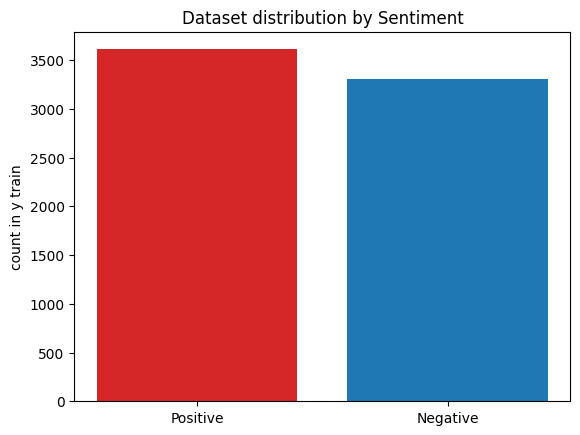

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

balance_train = ['Positive', 'Negative']
counts = [3610, 3310]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(balance_train, counts, color=bar_colors)

ax.set_ylabel('count in y train')
ax.set_title('Dataset distribution by Sentiment')

plt.show()

As shown in the graph, the classes are mostly balanced, so we do not neet to consider using some kind of resampling.

Text(0.5, 1.0, 'Review Length Distribution in X_train')

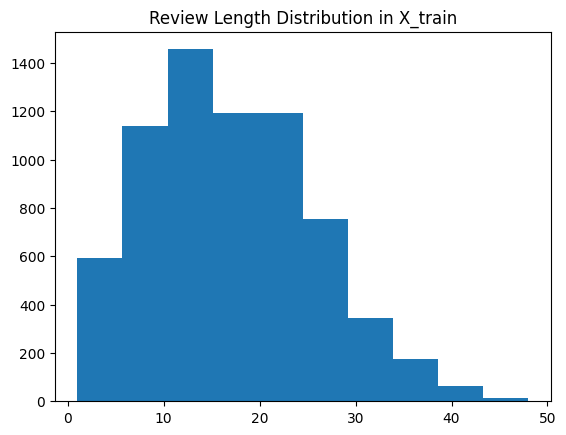

In [ ]:
# review lengths
import matplotlib.pyplot as plt

review_length = X_train.apply(lambda x: len(x.split()))
plt.hist(review_length)
plt.title("Review Length Distribution in X_train")

As shown in this graph, we can see that the review length of X_train varies, with longest review reaching 50 words. Therefore, as we proceed to step two, before buildiing deep learning models, we could consider padding the review into same length.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


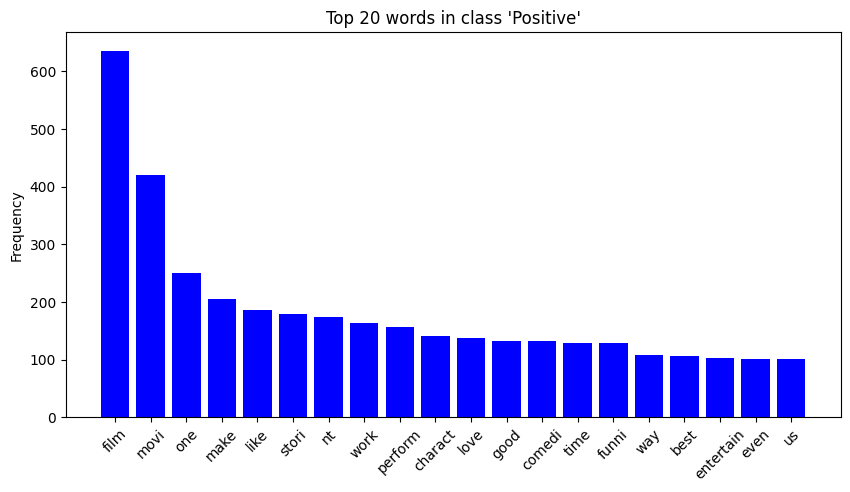

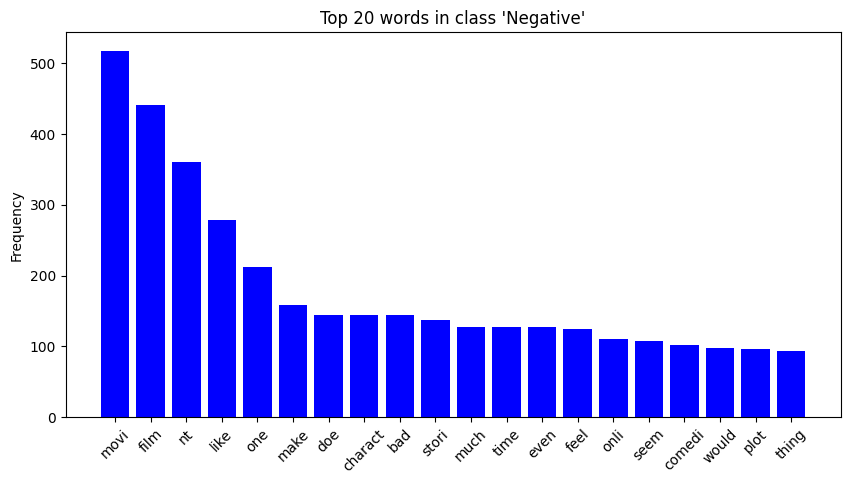

In [ ]:
# word frequency
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('punkt')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Tokenize and create a freq dict per class
word_freq = {}
classes = y_train_labels.unique()

for class_name in classes:
    text_data = X_train[y_train_labels == class_name]
    all_words = []
    for text in text_data:
        # Tokenize and stop words removal
        tokens = [word for word in word_tokenize(text) if word.lower() not in stop_words and word.isalpha()]
        all_words.extend(tokens)

    word_freq[class_name] = Counter(all_words)

# top N words per class
top_n = 20
for class_name, counter in word_freq.items():
    most_common = counter.most_common(top_n)
    words = [word for word, freq in most_common]
    frequencies = [freq for word, freq in most_common]


    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies, color='blue')
    plt.title(f"Top {top_n} words in class '{class_name}'")
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

As shown in the bar plots above, word frequency in positive and negative classed corpuses are different to a certain extent.
Both contain theme words like "movie", "film", "story" and "character". Both contain common verbs and prepositions and adverbs like "feel", "like", "make" and "even".
Positive corpuses contain specific words like "funny", "best", etc.
Negative corpuses contain specific words like "bad".


---

Moreover, these plots again proves that setting max_df to 200 is reasonable, because we can exclude words that are common in the context and not helpful to classification like "movie" and "film" which has a max count over 200 in both target classes. As shown in the plots, words below 200 act as a more stronger indicator in target classes like "best", "funny" in positive, "only" in negative.

##3.   Non Deep Learning Approach
Make text lowercase, remove text in square brackets, remove links, remove punctuation, remove words containing numbers, stem, build a Document-Term Matrix (DTM) out of training data and build TF-IDF matrix.

### 3.1 Preprocess
Make text lowercase, remove text in square brackets, remove links, remove punctuation, remove words containing numbers, stem, build a Document-Term Matrix (DTM) out of training data and build TF-IDF matrix.

In [ ]:
def to_series(df):
  ## Complete this function to convert to series if there is only one column, else keep as dataframe. [1 Pts]
  if df.shape[1] == 1:
    df = df.squeeze()
  return df

In [ ]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
import nltk
stemmer = nltk.SnowballStemmer("english")
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
def clean_data(text):
    text = clean_text(text)
    text = stemm_text(text)

    return text

X_train['text_clean'] = X_train['text'].apply(clean_data)
X_test['text_clean'] = X_test['text'].apply(clean_data)

X_train=to_series(X_train[['text_clean']])
X_test=to_series(X_test[['text_clean']])
y_train_labels=to_series(y_train_labels)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=10, max_df=200)
vect_tunned.fit(X_train)
x_train_dtm = vect_tunned.transform(X_train)

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_train_dtm)

TfidfTransformer()

In [ ]:
def preprocessor(data):
  data_dtm = vect_tunned.transform(data)
  data_dtm_tfidf = tfidf_transformer.transform(data_dtm)
  return data_dtm_tfidf

print(preprocessor(X_train).shape)
print(preprocessor(X_test).shape)

(6920, 1291)
(1821, 1291)


### 3.2 Build Model - SVC

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_train_labels)

In [ ]:
from sklearn.svm import SVC

X_train_preprocessed = preprocessor(X_train)
X_test_preprocessed = preprocessor(X_test)

modelSVC = SVC()
modelSVC.fit(X_train_preprocessed, y_encoded)
prediction_labels = encoder.inverse_transform(modelSVC.predict(preprocessor(X_test)))

### 3.3 Performance Evaluation

In [ ]:
data = mycompetition.get_leaderboard()
test_metric = data[data['version'].isin([492])][['model_type', 'accuracy', 'f1_score', 'precision', 'recall']]

def train_data(models, X_train_preprocessed, y_encoded):
  from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
  train_df = pd.DataFrame()
  train_df['model_type'] = ['SVC']
  f1_metrics = []
  precision_score_metrics = []
  accuracy_score_metrics = []
  recall_score_metrics = []
  for model in models:
    prediction_labels = model.predict(X_train_preprocessed)
    f1_metric = f1_score(y_encoded, list(prediction_labels))
    precision_score_metric = precision_score(y_encoded, list(prediction_labels))
    accuracy_score_metric = accuracy_score(y_encoded, list(prediction_labels))
    recall_score_metric = recall_score(y_encoded, list(prediction_labels))
    f1_metrics.append(f1_metric)
    precision_score_metrics.append(precision_score_metric)
    accuracy_score_metrics.append(accuracy_score_metric)
    recall_score_metrics.append(recall_score_metric)
  train_df['accuracy_train'] = accuracy_score_metrics
  train_df['f1_train'] = f1_metrics
  train_df['precision_train'] = precision_score_metrics
  train_df['recall_train'] = recall_score_metrics
  return train_df

models = [modelSVC]
train_metric = train_data(models, X_train_preprocessed,y_encoded)

In [ ]:
tabularized_model_results = pd.merge(test_metric, train_metric, on="model_type")
tabularized_model_results

,model_type,accuracy,f1_score,precision,recall,accuracy_train,f1_train,precision_train,recall_train
0,SVC,0.765093,0.765011,0.765506,0.765115,0.951156,0.952885,0.959035,0.946814


We trained SVC along with RF, bagging and other ML models, and the SVC model has the highest test accuracy, F1 score, precision, and recall. It is consistent across all metrics for the test set, suggesting it might be the best generalizer among the models evaluated for unseen data.

Support vector is especially good at handling high-dimension data like text and in performing simple classification task like the one here. Therefore, it is no surprise that SVC is the best model among all ML models we've trained.

## 4. Deep Learning Approaches

### 4.1 Use keras-tuner to build a LSTM model

In [ ]:
# preprocess and tokenize using keras tokenizer
X_train = X_train.squeeze()
X_test = X_test.squeeze()
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
y_encoded = encoder.fit_transform(y_train_labels)
y_encoded = y_encoded.toarray()

# tf.keras tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np

def preprocessor(txt_in):
    # Tokenize words
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(txt_in)
    sequences = tokenizer.texts_to_sequences(txt_in)

    padded_sequences = pad_sequences(sequences, maxlen=40, padding='post')
    return padded_sequences, tokenizer

X_train_padded, tokenizer = preprocessor(X_train)
X_test_padded, _ = preprocessor(X_test)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

13836


The vocabulary size of training data is 13836, which can be used to define input dimension when constructing embedding layers later.

In [ ]:
# validation split
from sklearn.model_selection import train_test_split
x_train_split, x_val, y_train_split, y_val = train_test_split(
     X_train, y_train_labels, test_size=0.2, random_state=42)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten
import keras_tuner as kt

def build_model(hp):
  model_tuned = Sequential([
      Embedding(input_dim=vocab_size, output_dim=200, input_length=40),
      LSTM(units=hp.Int("units", min_value=32, max_value=128, step=16),
           recurrent_dropout=hp.Float("recurrent_dropout", min_value=0, max_value=0.5, step=0.25),
           return_sequences=True),
      LSTM(units=hp.Int("units", min_value=32, max_value=128, step=16),
           recurrent_dropout=hp.Float("recurrent_dropout", min_value=0, max_value=0.5, step=0.25),
           return_sequences=True),
      LSTM(units=hp.Int("units", min_value=32, max_value=128, step=16),
           recurrent_dropout=hp.Float("recurrent_dropout", min_value=0, max_value=0.5, step=0.25)),
      Dense(2, activation='softmax')
  ])
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model_tuned.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )
  return model_tuned

build_model(kt.HyperParameters())

In [ ]:
import tensorflow as tf
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="/content/",
    project_name="nn_tuned",
)

x_train_split_padded, _ = preprocessor(x_train_split)
x_val_padded, _ = preprocessor(x_val)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train_split_padded, encoder.fit_transform(y_train_split).toarray(),
             epochs=10, validation_data=(x_val_padded, encoder.fit_transform(y_val).toarray()),
             callbacks=[stop_early])
tuner.search_space_summary()

Trial 3 Complete [00h 04m 27s]
val_loss: 0.6913886368274689

Best val_loss So Far: 0.6887591183185577
Total elapsed time: 00h 21m 21s
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
recurrent_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.25, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


The best hyperparameters are: units=32, recurrent_dropout=0.5 and lr≈8.3e-3.
* Units: because the data is small and the task is simple, so it only takes a small amount of nodes to perform the task.
* Recurrent_dropout: because the data is small, even if we only used 32 nodes per layer, there is still going to be overfitting. So dropout is added to each layer to alleviate overfitting.
* Learning rate: the learning rate tuner chooses is relatively small in the [1e-4, 1e-2] range. This can still boil down to small dataset. Small parameter space doesn't require big lr to search it. Instead, smaller lr can better find minimum.

In [ ]:
# get the best model of keras tuner
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 200)           2767200   
                                                                 
 lstm (LSTM)                 (None, 40, 96)            114048    
                                                                 
 lstm_1 (LSTM)               (None, 40, 96)            74112     
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dense (Dense)               (None, 2)                 194       
                                                                 
Total params: 3029666 (11.56 MB)
Trainable params: 3029666 (11.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Build and train model with the best hp.
model_tuned_best = Sequential([
    Embedding(input_dim=vocab_size, output_dim=200, input_length=40),
    LSTM(96, recurrent_dropout=0.5, return_sequences=True),
    LSTM(96, recurrent_dropout=0.5, return_sequences=True),
    LSTM(96, recurrent_dropout=0.5),
    Dense(2, activation='softmax')
])
learning_rate = 0.0008334295734522584
model_tuned_best.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

checkpoint_filepath = '/content/best_ktuner.h5'
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3),
          keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_loss',mode='min',save_best_only=True)]

history = model_tuned_best.fit(X_train_padded, y_encoded, epochs=10, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/10
173/173 [==============================] - 55s 276ms/step - loss: 0.6068 - accuracy: 0.6750 - val_loss: 0.7615 - val_accuracy: 0.6539 - lr: 8.3343e-04
Epoch 2/10
173/173 [==============================] - 45s 258ms/step - loss: 0.3320 - accuracy: 0.8698 - val_loss: 0.6753 - val_accuracy: 0.6221 - lr: 8.3343e-04
Epoch 3/10
173/173 [==============================] - 45s 261ms/step - loss: 0.1568 - accuracy: 0.9483 - val_loss: 0.6907 - val_accuracy: 0.7616 - lr: 8.3343e-04
Epoch 4/10
173/173 [==============================] - 46s 263ms/step - loss: 0.0945 - accuracy: 0.9707 - val_loss: 0.8322 - val_accuracy: 0.7009 - lr: 8.3343e-04
Epoch 5/10
173/173 [==============================] - 44s 253ms/step - loss: 0.0841 - accuracy: 0.9774 - val_loss: 1.1444 - val_accuracy: 0.6871 - lr: 8.3343e-04
Epoch 6/10
173/173 [==============================] - 44s 257ms/step - loss: 0.0387 - accuracy: 0.9902 - val_loss: 1.1697 - val_accuracy: 0.6944 - lr: 8.3343e-05
Epoch 7/10
173/173 [========

In [ ]:
# define a function to plot history of deep learning training history
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure(figsize=(10, 5))

  # Plot training & validation loss values
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot training & validation accuracy values
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

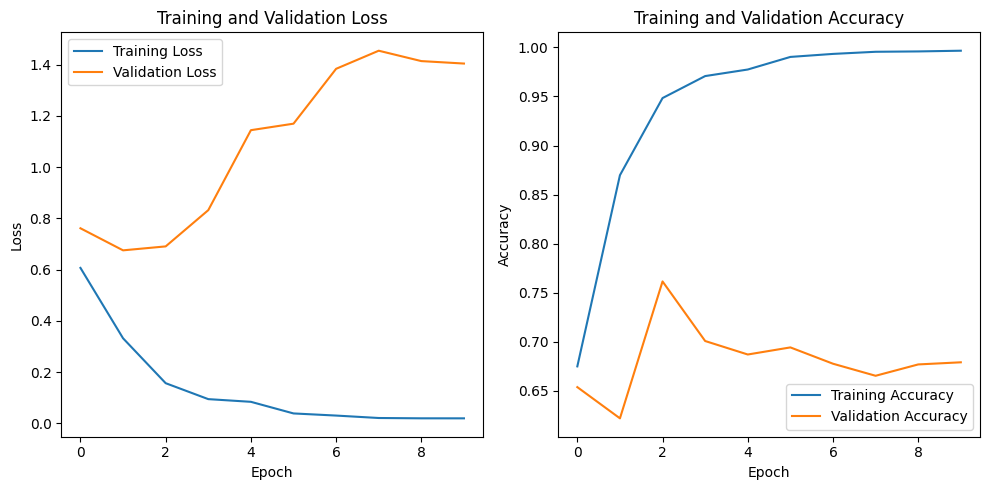

In [ ]:
plot_history(history.history)
pd.DataFrame(history.history).to_csv('training_history_ktuner.csv')

As the graph above shows, there are still some signs of overfitting after the 2nd epoch. Although we defined dropout rate of 0.5 across all LSTM layers through keras tuner, the model still overfits. It may be because the task is rather simple and 10 epoch is too much for the model to learn all necessary details, and hence it starts to overfit to increase performance.

That being said, the best validation accuracy of this LSTM model is 76%, which is not very ideal but decent enough.

### 4.2 Transfer learning with GloVe Embeddings

In [ ]:
# download glove embeddings
import os
import zipfile
import urllib.request

url = "http://nlp.stanford.edu/data/glove.6B.zip"
filename = 'glove.6B.zip'
filepath = os.path.join('./', filename)
if not os.path.isfile(filepath):
    print('Download GloVe embeddings')
    urllib.request.urlretrieve(url, filename)
    print('Download completed.')
#unzip
if not os.path.isdir('./glove.6B'):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        print('Extracting GloVe embeddings...')
        zip_ref.extractall('./glove.6B')
        print('Extraction completed.')

Download GloVe embeddings
Download completed.


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

def load_glove_embeddings(path, embedding_dim):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings('./glove.6B/glove.6B.200d.txt', 200)

embedding_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# model with GloVe embeddings
model_with_glove = Sequential([
    Embedding(input_dim=vocab_size, output_dim=200, input_length=40, weights=[embedding_matrix], trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model
model_with_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/best_glove.h5'
callbacks_list_glove = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)
]

history_glove = model_with_glove.fit(X_train_padded, y_encoded, epochs=10, validation_split=0.2, callbacks=callbacks_list_glove)

Epoch 1/10
173/173 [==============================] - 5s 24ms/step - loss: 0.6017 - accuracy: 0.6584 - val_loss: 0.5896 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 2/10
173/173 [==============================] - 4s 21ms/step - loss: 0.4323 - accuracy: 0.8018 - val_loss: 0.3504 - val_accuracy: 0.8916 - lr: 0.0010
Epoch 3/10
173/173 [==============================] - 5s 27ms/step - loss: 0.3050 - accuracy: 0.8703 - val_loss: 0.9254 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 4/10
173/173 [==============================] - 6s 36ms/step - loss: 0.1763 - accuracy: 0.9368 - val_loss: 0.6971 - val_accuracy: 0.7681 - lr: 0.0010
Epoch 5/10
173/173 [==============================] - 6s 37ms/step - loss: 0.1110 - accuracy: 0.9588 - val_loss: 0.6959 - val_accuracy: 0.8013 - lr: 0.0010
Epoch 6/10
173/173 [==============================] - 6s 35ms/step - loss: 0.0466 - accuracy: 0.9870 - val_loss: 1.0294 - val_accuracy: 0.7486 - lr: 1.0000e-04
Epoch 7/10
173/173 [==============================] - 6s 35m

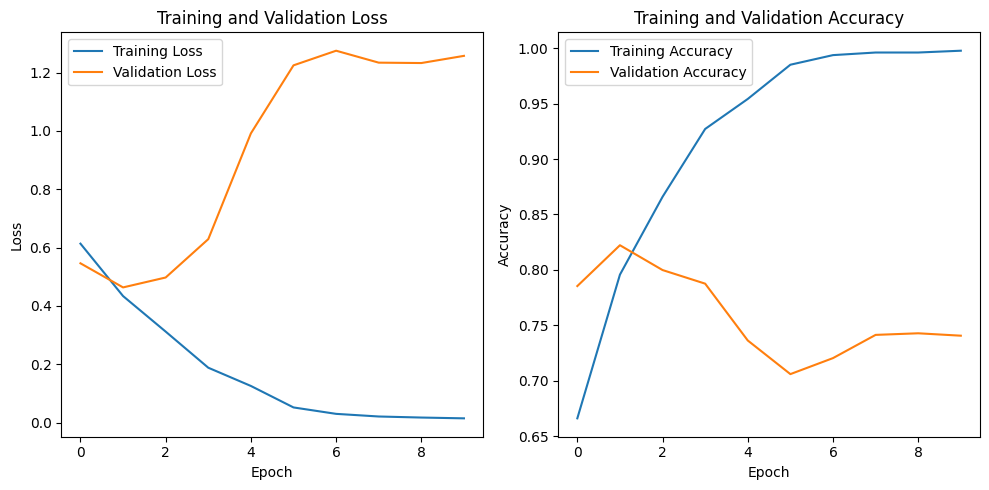

In [ ]:
plot_history(history_glove)

The glove model also shows signs of overfitting after 2-3 epochs, but the overall performance exceeds the previous LSTM model.

### 4.3 Bert-based Model

In [ ]:
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

max_length = 128
# Data preparation function
def prepare_data_bert(texts, tokenizer, max_length):
    tokenized = tokenizer(texts, max_length=max_length, truncation=True, padding='max_length', return_tensors="tf")
    return {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask']
    }
X_train_bert=pd.read_csv("sst2_competition_data/X_train.csv")['text'].to_list()
# X_train_bert = [[text] for text in X_train_bert]
train_data = prepare_data_bert(X_train_bert, tokenizer, max_length)
y_encoded_bert = np.array([[i][0][0] for i in y_encoded])

In [ ]:
# Freeze BERT layers
for layer in bert.layers:
    layer.trainable = False

# Model configuration
input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
outputs = bert(input_ids, attention_mask=attention_mask)
embeddings = outputs.pooler_output
sequence_output = outputs.last_hidden_state[:, 0, :]  # First token ([CLS])
output = Dense(1, activation='sigmoid')(sequence_output)


# Model compilation
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model_bert.summary()

# Callbacks configuration
checkpoint_filepath = '/content/best_bert.h5'
callbacks_list_bert = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)
]

# Model training
history_bert = model_bert.fit(
    train_data,
    y_encoded_bert,
    epochs=5,
    validation_split=0.2,
    callbacks=callbacks_list_bert
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

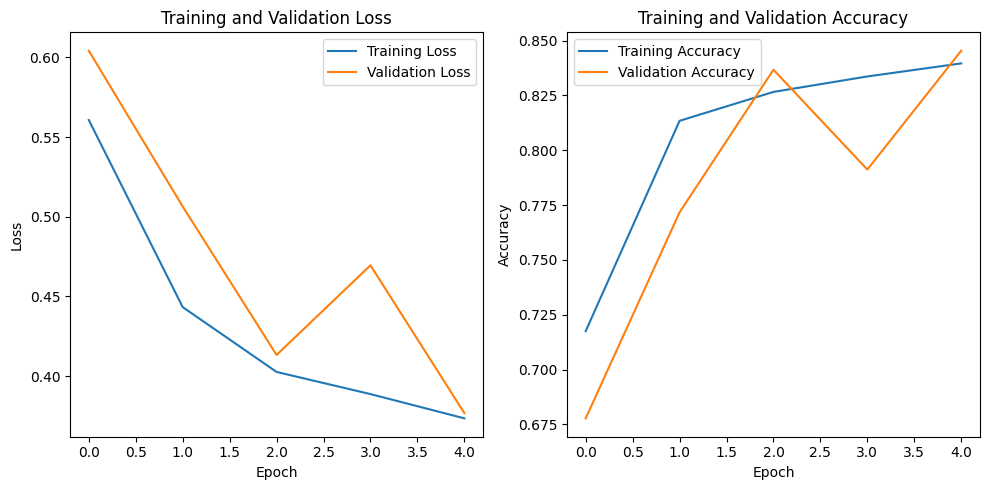

In [ ]:
history_bert = pd.read_csv('history_bert.csv')
plot_history(history_bert)

As the graph above shows, the BERT-based model **doesn't show any sign of overfitting**. We chose epoch=10 to save computation time, but it still hasn't converge, so an ideal solution is to increase epoch and see the train & validation performance throughout more epochs until it starts to overfit.

This difference on overfitting between regular deep learning models and transformer models can be attributed to the following:
1. Attention Mechanism: helps in learning long-range dependencies more effectively compared to regular neural networks
2. Pre-trained on Large Datasets: BERT is trained on massive datasets, which helps in learning robust representations. The pre-trained embeddings often capture rich semantic and syntactic information, reducing the need for extensive training on task-specific data, which can help in avoiding overfitting.
3. Regularization Techniques: Transformer models employ more complex and advanced regularization techniques during training.

### 4.4 T5-based Model

In [ ]:
# preprocess and tokenize
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
import torch

tokenizer = T5Tokenizer.from_pretrained("t5-base")
train_data = [{"text": text, "label": label} for text, label in zip(x_train_split, y_train_split.squeeze())]
val_data = [{"text": text, "label": label} for text,label in zip(x_val, y_val.squeeze())]
def preprocess_data(data):
    tokenized_data = []
    for item in data:
        text = item["text"]
        sentiment = item["label"]
        tokenized_text = tokenizer.encode_plus(
            f"{text}",
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        tokenized_data.append(
            {
                "input_ids": tokenized_text["input_ids"].flatten(),
                "attention_mask": tokenized_text["attention_mask"].flatten(),
                "labels": torch.tensor(1 if sentiment == "positive" else 0).unsqueeze(0),
            }
        )
    return tokenized_data

train_tokenized = preprocess_data(train_data)
val_tokenized = preprocess_data(val_data)

In [ ]:
# Model Architecture
class SentimentClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained("t5-base")

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        return outputs.loss, outputs.logits

model = SentimentClassifier()

training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=1,
    # per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    save_steps = 2000,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
)
trainer.train()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Step,Training Loss,Validation Loss
100,3.470300,0.000083
200,0.008400,0.000001
300,0.004700,0.000000
400,0.000100,0.000000
500,0.004900,0.000000
600,0.000000,0.000000


TrainOutput(global_step=692, training_loss=0.5041436982069251, metrics={'train_runtime': 979.4905, 'train_samples_per_second': 5.652, 'train_steps_per_second': 0.706, 'total_flos': 0.0, 'train_loss': 0.5041436982069251, 'epoch': 1.0})

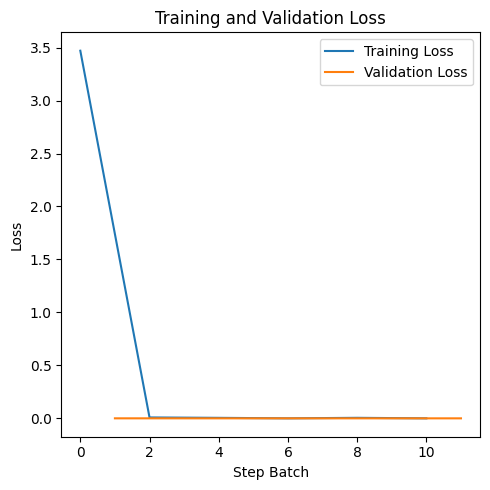

In [ ]:
import matplotlib.pyplot as plt
history = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(5, 5))
plt.plot(history['loss'].dropna(), label='Training Loss')
plt.plot(history['eval_loss'].dropna(), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Step Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The T5 model significantly increases performance on validation set.

### 4.5 Metrics
We trained the deep learning model on another 100 rows of unseen data to see their performance. Below are test loss and accuracy for all models we've trained.

In [ ]:
# tabulate the results
results = pd.DataFrame({
    'Model': ['CNN', 'bert', 'conv1d', 'glove', 'ktuner', 'lstm'],
    'Test Loss': [cnn_score[0], bert_score[0], conv1d_score[0], glove_score[0], ktuner_score[0], lstm_score[0]],
    'Test Accuracy': [cnn_score[1], bert_score[1], conv1d_score[1], glove_score[1], ktuner_score[1], lstm_score[1]]
})

print(results)

    Model  Test Loss  Test Accuracy
0     CNN   1.225108       0.444444
1    bert   0.413761       0.757576
2  conv1d   1.023822       0.505050
3   glove   1.151374       0.414141
4  ktuner   1.196877       0.454545
5    lstm   1.467752       0.505050


In [ ]:
t5_predictions = trainer.predict(train_tokenized_T5)
# Mapping dictionary
mapping = {0: "negative", 1: "positive"}
# Inverse transform
inverse_labels = [mapping[label.item()] for label in t5_predictions.label_ids]

from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(inverse_labels, y_test_sample)
print(f'Model: T5-based   Test Accuracy: {accuracy}')

Model: T5-based   Test Accuracy: 1.0


**Analysis on the results**

T5: T5 performs best with 100% accuracy. This can be foreseen since its training history performance is already unparalleled among other models. T5 is designed to be parameter-efficient compared to BERT. Therefore, it took less time in trainign with better results.

BERT: BERT performs second best with a test accuracy of approximately 75.76% and a low loss of 0.413761. This might be attributed to its robust architecture and tokenization method since it utilizes subword tokenization, which mitigates the issue of out-of-vocabulary words. Therefore, BERT is able to maintain high performance when I used the test_sample.csv to test its performances.

Other Models (CNN, conv1d, lstm, glove, ktuner): These models showed poorer performance compared to BERT, with accuracies ranging from 40% to 55%.
I think this might be because when the training data vocab size (as well as the input dim) is set at 13836, and the testset vocab size is drastically reduces to 4864. This might causing these models to have large number of zero-padding inputs or unseen words, and may cause ineffective embedding lookups and suboptimal feature extraction.